# Principle Component Analysis

This notebook discusses Principle Component Analysis in Detail using Horsecohlic DataSet. 
Data being used here  is 'Horse Colic Dataset' which predicts whether a horse can survive or not based on past medical conditions.
Data is available via following links.
1.  [Kaggle](http://www.kaggle.com/uciml/horse-colic)
2. [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

Importing required libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plots
#import seaborn as sns #fo
%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')

Reading data from **CSV file** and saving as **Pandas' Dataframe**

In [2]:
print(os.listdir("../input"))
data = pd.read_csv('../input/horse.csv')
data.head()

['datadict.txt', 'horse.csv']


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,outcome,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data
0,no,adult,530101,38.5,66.0,28.0,cool,reduced,NaN,more_3_sec,extreme_pain,absent,severe,NaN,NaN,NaN,decreased,distend_large,45.0,8.4,NaN,NaN,died,no,11300,0,0,no
1,yes,adult,534817,39.2,88.0,20.0,NaN,NaN,pale_cyanotic,less_3_sec,mild_pain,absent,slight,NaN,NaN,NaN,absent,other,50.0,85.0,cloudy,2.0,euthanized,no,2208,0,0,no
2,no,adult,530334,38.3,40.0,24.0,normal,normal,pale_pink,less_3_sec,mild_pain,hypomotile,none,NaN,NaN,NaN,normal,normal,33.0,6.7,NaN,NaN,lived,no,0,0,0,yes
3,yes,young,5290409,39.1,164.0,84.0,cold,normal,dark_cyanotic,more_3_sec,depressed,absent,severe,none,less_1_liter,5.0,decreased,NaN,48.0,7.2,serosanguious,5.3,died,yes,2208,0,0,yes
4,no,adult,530255,37.3,104.0,35.0,NaN,NaN,dark_cyanotic,more_3_sec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.0,7.4,NaN,NaN,died,no,4300,0,0,no


Data is then cleaned and converted to numeric form for processing and returned as **data_merge**.

Tutorial link for data cleaning - [Data Cleaning](http://www.kaggle.com/sabasiddiqi/data-examination-and-cleaning).

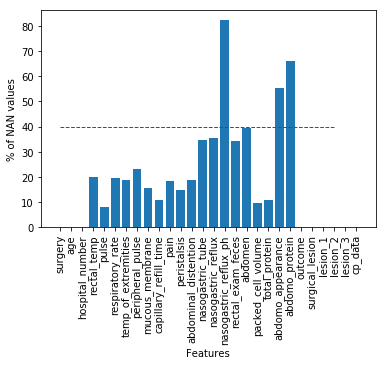

In [3]:
#print("Shape of data (samples, features): ",data.shape)
data.dtypes.value_counts()

nan_per=data.isna().sum()/len(data)*100
plt.bar(range(len(nan_per)),nan_per)
plt.xlabel('Features')
plt.ylabel('% of NAN values')
plt.plot([0, 25], [40,40], 'r--', lw=1)
plt.xticks(list(range(len(data.columns))),list(data.columns.values),rotation='vertical')

obj_columns=[]
nonobj_columns=[]
for col in data.columns.values:
    if data[col].dtype=='object':
        obj_columns.append(col)
    else:
        nonobj_columns.append(col)
#print(len(obj_columns)," Object Columns are \n",obj_columns,'\n')
#print(len(nonobj_columns),"Non-object columns are \n",nonobj_columns)

data_obj=data[obj_columns]
data_nonobj=data[nonobj_columns]

#print("Data Size Before Numerical NAN Column(>40%) Removal :",data_nonobj.shape)
for col in data_nonobj.columns.values:
    if (pd.isna(data_nonobj[col]).sum())>0:
        if pd.isna(data_nonobj[col]).sum() > (40/100*len(data_nonobj)):
            #print(col,"removed")
            data_nonobj=data_nonobj.drop([col], axis=1)
        else:
            data_nonobj[col]=data_nonobj[col].fillna(data_nonobj[col].median())
#print("Data Size After Numerical NAN Column(>40%) Removal :",data_nonobj.shape)

for col in data_obj.columns.values:
    data_obj[col]=data_obj[col].astype('category').cat.codes
data_merge=pd.concat([data_nonobj,data_obj],axis=1)

target=data['outcome']
temp=target
#print(target.value_counts())
target=data_merge['outcome']
#print(target.value_counts())

train_corr=data_merge.corr()
#sns.heatmap(train_corr, vmax=0.8)
corr_values=train_corr['outcome'].sort_values(ascending=False)
corr_values=abs(corr_values).sort_values(ascending=False)
#print("Correlation of mentioned features wrt outcome in ascending order")
#print(abs(corr_values).sort_values(ascending=False))

#print("Data Size Before Correlated Column Removal :",data_merge.shape)

for col in range(len(corr_values)):
        if abs(corr_values[col]) < 0.1:
            data_merge=data_merge.drop([corr_values.index[col]], axis=1)
            #print(corr_values.index[col],"removed")
#print("Data Size After Correlated Column Removal :",data_merge.shape)

In [4]:
data_merge.head()

,hospital_number,pulse,packed_cell_volume,total_protein,lesion_1,surgery,age,temp_of_extremities,capillary_refill_time,pain,peristalsis,rectal_exam_feces,abdomen,abdomo_appearance,outcome,surgical_lesion
0,530101,66.0,45.0,8.4,11300,0,0,1,2,2,0,1,0,-1,0,0
1,534817,88.0,50.0,85.0,2208,1,0,-1,1,3,0,0,4,1,1,0
2,530334,40.0,33.0,6.7,0,0,0,2,1,3,2,3,3,-1,2,0
3,5290409,164.0,48.0,7.2,2208,1,1,0,2,1,0,1,-1,2,0,1
4,530255,104.0,74.0,7.4,4300,0,0,-1,2,-1,-1,-1,-1,-1,0,0


## Principle Component Analysis 

### Dimensionality Reduction

When dealing with high-dimensional data it is difficult to visualize or interpret the data; such data sometimes has data redundancy issue due to multicorrelated features. Also, as the number of dimensions increases, computation time and power increases as well. These issues can be solved using ***Dimensionality Reduction***. 

It is the process of reducing the number of random variables under considertion (also known as features) without losing information. It does so by obtaining a set of principle variables. Thus,
1. Reducing storage space and compress data 
2. Reduce Computation Time and Power
3. Deals with multicolinearity, i.e. deals with redundant data
4. Helps in data visualization and interpretation (e.g. Projection into two dimensions)

### Principle Component Analysis

One way to perform Dimensionality Reduction is through ***Principle Component Analysis (PCA)*** . It is a linear transformation technique used to identify strong patterns in data by finding out variable correlation. It maps the data to a lower dimensional subspace in a way that data variance is maximized while retaining most of the information.

Steps to perform PCA:
* Step 1. [Data Standardization](#step1) 
* Step 2: [Covariance Matrix](#step2)
* Step 3: [Eigen Decomposition of Covariance Matrix](#step3)
* Step 4: [Projection Onto New Feature Space](#step4)


## <a id='step1'>Step 1 - Data Standardization</a>

As PCA deals with variance maximization of two variables, it is important to have both variables on same scale. 


In [5]:
data.describe()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3
count,2.990000e+02,239.000000,275.000000,241.000000,53.000000,270.000000,266.000000,101.000000,299.000000,299.000000,299.000000
mean,1.087733e+06,38.168619,72.000000,30.460581,4.707547,46.307407,24.274436,3.039604,3659.709030,90.528428,7.387960
std,1.532032e+06,0.733744,28.646219,17.666102,1.982311,10.436743,27.364194,1.967947,5408.472421,650.637139,127.749768
min,5.184760e+05,35.400000,30.000000,8.000000,1.000000,23.000000,3.300000,0.100000,0.000000,0.000000,0.000000
25%,5.289040e+05,37.800000,48.000000,18.000000,3.000000,38.000000,6.500000,2.000000,2111.500000,0.000000,0.000000
50%,5.303010e+05,38.200000,64.000000,25.000000,5.000000,45.000000,7.500000,2.300000,2322.000000,0.000000,0.000000
75%,5.347360e+05,38.500000,88.000000,36.000000,6.500000,52.000000,56.750000,3.900000,3209.000000,0.000000,0.000000
max,5.305629e+06,40.800000,184.000000,96.000000,7.500000,75.000000,89.000000,10.100000,41110.000000,7111.000000,2209.000000


In [6]:
from sklearn.preprocessing import StandardScaler
Xstd = StandardScaler().fit_transform(data_merge)

## <a id='step2'>Step 2 - Covariance Matrix</a>

The standardized data  is then used to find covariance matrix. We need covariance matrix to find eigen values and vectors in the next step. 

A Covariance Matrix is used to analyze linear relationship between two variable, i.e. how the variables change together. 
Lets say we have two random variables x and y, 
* if x increases as y increases -> positive linear relationship ***(+ve covariance value)***
* if x decreases as y decreases -> positive linear relationship ***(+ve covariance value)***
* if x increases as y decreases -> negative linear relationship  ***(-ve covariance value)***
* if x decreases as y increases -> negative linear relationship  ***(-ve covariance value)***

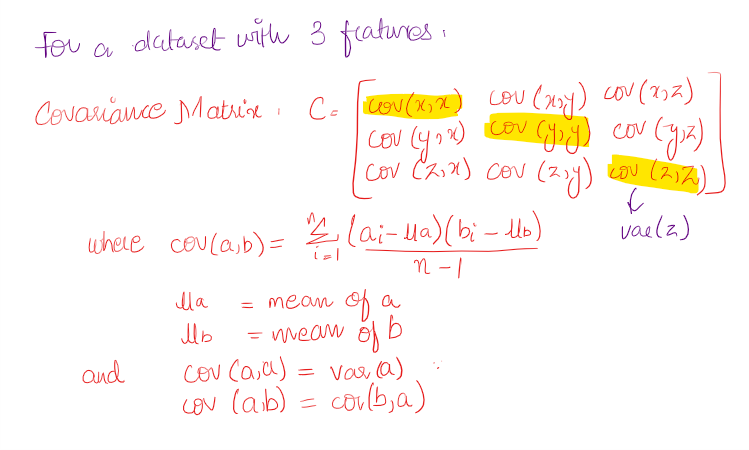

In [7]:
print('Covariance matrix: \n', np.cov(Xstd.T))

Covariance matrix: 
 [[ 1.0033557   0.33826189 -0.08929155 -0.2163231   0.14588534  0.12646677
   0.69967134 -0.05864493 -0.09267838 -0.04752765 -0.15256643 -0.04788999
  -0.21406215 -0.04509423 -0.10675297  0.10276892]
 [ 0.33826189  1.0033557   0.37123415 -0.08339985  0.07231578  0.17659169
   0.50707016 -0.14600068  0.24712728  0.12369663 -0.12120542 -0.17330301
  -0.18497465  0.26717331 -0.33667603  0.25421528]
 [-0.08929155  0.37123415  1.0033557  -0.0527549  -0.06669085  0.0387464
  -0.14253551 -0.11811727  0.32804813  0.02761471 -0.19787345 -0.20691672
  -0.01455649  0.1740628  -0.39970752  0.16481172]
 [-0.2163231  -0.08339985 -0.0527549   1.0033557  -0.16920337  0.03237067
  -0.10590435  0.0122716  -0.05678842 -0.03589256  0.01981662 -0.01781807
  -0.00918374 -0.06378546  0.26678131 -0.12478886]
 [ 0.14588534  0.07231578 -0.06669085 -0.16920337  1.0033557   0.16449021
   0.02294682  0.03365745  0.0439455   0.05363456  0.00475313 -0.0272977
  -0.06248915  0.03807052 -0.10107584

## <a id='step3'>Step 3 - Eigen Decomposition of Covariance Matrix</a>

When a random vector is multiplies by a covarinace matrix, it moves towards the direction of greatest variation. In this way we can extract dimension with greatest 
spread of data. 

One way to do it, is to find the exact vector that doesn't converge (i.e. its direction doesnt change), means it is already giving the maximum data variance.
It is done by computing eigen values and vectors where eigen values represent the scale of vector and eigen vector represent the direction, given by

***Covariance Matrix x Vector = Scalar Component x Vector***

where, Vector is the eigen vector 
            and Scalar component is the eigen value
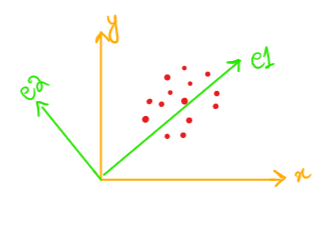
            

In [8]:
cov_mat = np.cov(Xstd.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)
print('Eigen vectors \n',eigen_vectors)
print('\nEigen values \n',eigen_values)

Eigen vectors 
 [[-2.68625569e-01 -1.84322456e-01 -5.08338915e-01  8.98616985e-02
   1.68872229e-02 -4.51347047e-01 -5.36071189e-02  2.39064110e-01
   3.87734686e-01 -3.45566462e-01 -1.21856625e-02  1.81447646e-01
  -2.13091237e-01  3.91668301e-02 -1.12548451e-01 -3.03657049e-02]
 [-3.85413450e-01  1.26649287e-01 -1.67792916e-01  3.10624981e-01
  -2.29707973e-01 -4.38120416e-01 -1.02361982e-02 -2.53617926e-01
  -2.78890010e-01  4.83707953e-01 -2.20859037e-01 -1.72428353e-01
   9.17517863e-02 -1.39520766e-02  3.81421678e-02 -3.60673771e-02]
 [-2.21386996e-01  2.12211984e-01  3.44855082e-01  4.19804195e-01
   2.92248612e-02  2.45810402e-01 -4.93952535e-02 -3.09378209e-02
   5.80369799e-01  1.80307479e-01 -1.98106996e-01  2.41696802e-01
  -6.53830866e-02  2.62971547e-01  2.61745660e-02 -7.07226233e-02]
 [ 1.41700349e-01 -7.49416254e-02  1.69000649e-01 -9.72957003e-02
  -6.92475240e-01 -4.38736686e-02 -2.06867186e-01  1.84179480e-01
   1.64776946e-02 -1.96215246e-01 -2.85183192e-01  6.1608

Now, 
Making list of eigen values and vectors and sorting the list w.r.t eigen values (Descending order) where highest eigen values represent highest variation. 

In [9]:
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs.sort()
pairs.reverse()

print('Eigen Values in descending order:')
for i in pairs:
    print(i[0])

Eigen Values in descending order:
3.0904113533215525
2.220975625436714
1.8090815646545253
1.4645163497862097
1.1646384241094003
0.9656842372225789
0.8317441230906544
0.7460082985449134
0.6789127953138906
0.657349836230231
0.5745527125087295
0.5107828447778722
0.4421215825528471
0.37969831396207837
0.31310689869011493
0.2041063149654855


To check how much aech Principle component represent variation, let us find the cumulative sum of eigen values and plot them.

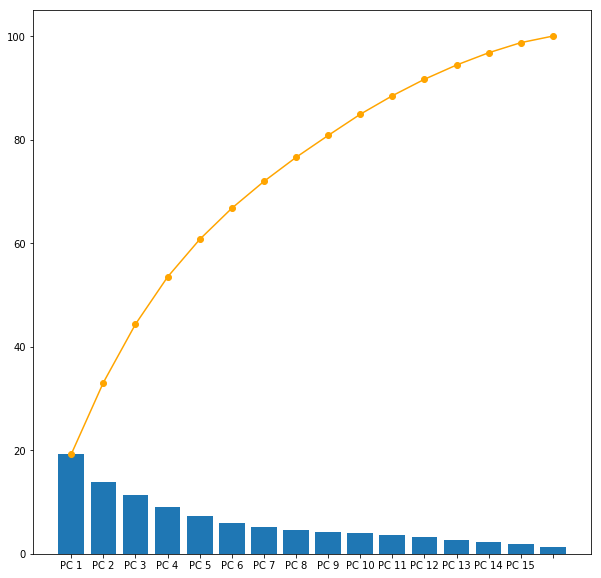

In [10]:
tot = sum(eigen_values)
var_per = [(i / tot)*100 for i in sorted(eigen_values, reverse=True)]
cum_var_per = np.cumsum(var_per)

plt.figure(figsize=(10,10))
x=['PC %s' %i for i in range(1,len(var_per))]
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xticks(ind,x);
plt.plot(ind,cum_var_per,marker="o",color='orange')
plt.xticks(ind,x);


Plot shows that first component bears almost 20% of information, and first 9 components carry 80% information.

## <a id='step4'>Step 4 - Projection onto New Feature Space</a>

Reshaping eigen pairs to form a projection matrix, which is then multiplied by samples to transform data to new feature space

In [11]:
N=16
value=10
a = np.ndarray(shape = (N, 0))
for x in range(1,value):
    b=pairs[x][1].reshape(16,1)
    a = np.hstack((a,b))
print("Projection Matrix:\n",a)

Projection Matrix:
 [[-1.84322456e-01 -5.08338915e-01  8.98616985e-02  1.68872229e-02
  -5.36071189e-02 -1.21856625e-02  3.91668301e-02 -3.03657049e-02
  -1.12548451e-01]
 [ 1.26649287e-01 -1.67792916e-01  3.10624981e-01 -2.29707973e-01
  -1.02361982e-02 -2.20859037e-01 -1.39520766e-02 -3.60673771e-02
   3.81421678e-02]
 [ 2.12211984e-01  3.44855082e-01  4.19804195e-01  2.92248612e-02
  -4.93952535e-02 -1.98106996e-01  2.62971547e-01 -7.07226233e-02
   2.61745660e-02]
 [-7.49416254e-02  1.69000649e-01 -9.72957003e-02 -6.92475240e-01
  -2.06867186e-01 -2.85183192e-01 -4.62195615e-03 -4.30023348e-01
  -7.08028907e-02]
 [ 7.89809144e-02 -1.31210993e-01 -3.29041243e-01  4.63566384e-01
  -2.41522710e-01 -5.71882862e-01 -3.33944556e-01 -2.53604101e-01
   1.36177438e-01]
 [ 8.46304860e-02  5.43050715e-02 -5.03590233e-01 -2.02529078e-01
   1.09136275e-01 -9.78392949e-02  3.42340936e-01  1.56559141e-01
  -1.03834428e-01]
 [-1.67613560e-01 -5.38349284e-01  1.61543086e-01 -2.01163283e-01
   5.999

In [12]:
Y = Xstd.dot(a)

Now comparing data visualization before and after PCA, (1st Principle Component vs 2nd)

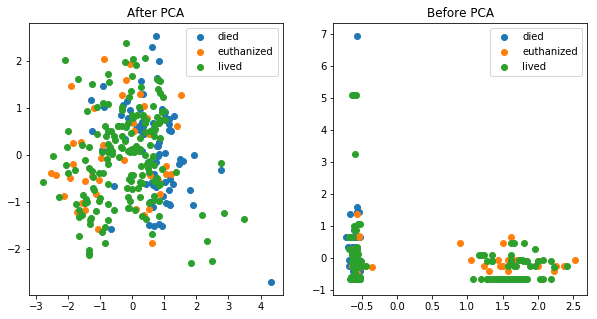

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for name in ('died', 'euthanized', 'lived'):
    plt.scatter(
        x=Y[temp==name,3],
        y=Y[temp==name,4],
    )
plt.legend( ('died', 'euthanized', 'lived'))
plt.title('After PCA')

plt.subplot(1,2,2)
for name in ('died', 'euthanized', 'lived'):
    plt.scatter(
        x=Xstd[temp==name,3],
        y=Xstd[temp==name,4],
    )
plt.title('Before PCA')
plt.legend( ('died', 'euthanized', 'lived'))


**Reerences:**

[Principle Component Analysis in Python](http://plot.ly/ipython-notebooks/principal-component-analysis/)

In [14]:
#add PCA ckitlearn shortcut